#Create the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/ESoWC

/content/drive/My Drive/ESoWC


In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot

#Load dataset and clean

In [4]:
dataset = xr.open_dataset('dataset_complete_for_model_CO.nc')
dataset

<xarray.Dataset>
Dimensions:            (Days: 31, Hours: 24, lat: 47, long: 47)
Coordinates:
  * lat                (lat) float64 43.0 43.25 43.5 43.75 ... 50.5 50.75 51.0
  * long               (long) float64 4.0 4.25 4.5 4.75 ... 11.5 11.75 12.0
  * Days               (Days) int64 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * Hours              (Hours) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables: (12/22)
    EMISSIONS_2019     (lat, long, Days, Hours) float32 ...
    u10                (lat, long, Days, Hours) float32 ...
    v10                (lat, long, Days, Hours) float32 ...
    hcc                (lat, long, Days, Hours) float32 ...
    lcc                (lat, long, Days, Hours) float32 ...
    tcc                (lat, long, Days, Hours) float32 ...
    ...                 ...
    tcco               (lat, long, Days, Hours) float64 ...
    tcno2              (lat, long, Days, Hours) float64 ...
    tc_no              (lat, long, Days, Hours) float64 ...
    gtco3              (lat, long, Days, Hours) float64 ...
    tcwv               (lat, long, Days, Hours) float64 ...
    traffic            (lat, long, Days, Hours) float64 ...

In [5]:
df = dataset.to_dataframe()
df = df.dropna()
df.head()

EMISSIONS_2019       u10  ...       tcwv    traffic
Days Hours lat  long                            ...                      
1    12    44.5 8.5     1.937331e-10  1.151261  ...  12.534024   0.000000
     13    44.5 8.5     1.971024e-10  1.192059  ...  12.323180  85.445255
     14    44.5 8.5     1.920485e-10  1.232856  ...  12.112337  84.904842
     15    44.5 8.5     1.954177e-10  1.273654  ...  11.901493  85.746872
     16    44.5 8.5     2.190026e-10  1.036139  ...  11.753887  77.719917

[5 rows x 22 columns]

#Normalizing

In [6]:
df_flat= df.reset_index()
df_flat.head()

,Days,Hours,lat,long,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,tot_wind,tmp_shift_8,tot_wind_shift_12,height,built,tcco,tcno2,tc_no,gtco3,tcwv,traffic
0,1,12,44.5,8.5,1.937331e-10,1.151261,1.565244,0.005661,-2.980232e-08,0.025514,0.233412,0.659459,98100.914062,265.990814,0.000004,1.943036,262.449432,2.532905,0.465535,0.012333,0.000901,0.000002,8.727168e-07,0.007997,12.534024,0.000000
1,1,13,44.5,8.5,1.971024e-10,1.192059,1.865819,0.003774,6.510417e-04,0.018271,0.233412,0.659459,98062.578125,265.965332,0.000004,2.214110,261.694916,2.347736,0.465535,0.012333,0.000897,0.000002,8.526965e-07,0.007977,12.323180,85.445255
2,1,14,44.5,8.5,1.920485e-10,1.232856,2.166394,0.001887,1.302113e-03,0.011028,0.233412,0.659459,98024.242188,265.939880,0.000004,2.492629,260.940369,2.190543,0.465535,0.012333,0.000893,0.000002,8.326761e-07,0.007957,12.112337,84.904842
3,1,15,44.5,8.5,1.954177e-10,1.273654,2.466970,0.000000,1.953185e-03,0.003784,0.233412,0.659459,97985.906250,265.914398,0.000004,2.776352,261.622223,2.067715,0.465535,0.012333,0.000890,0.000002,8.126558e-07,0.007937,11.901493,85.746872
4,1,16,44.5,8.5,2.190026e-10,1.036139,2.401013,0.001556,1.668344e-03,0.006104,0.233412,0.659459,97972.820312,265.880432,0.000004,2.615042,262.304108,1.826341,0.465535,0.012333,0.000889,0.000002,7.160276e-07,0.007932,11.753887,77.719917


In [7]:
X = df_flat.drop(columns = ['EMISSIONS_2019'])
y = df_flat['EMISSIONS_2019']

input_variables = X.columns
target_variable = 'EMISSIONS_2019'

seed = 1234

In [8]:
scaler = MinMaxScaler()
df_sc = scaler.fit_transform(df_flat)

df_norm = pd.DataFrame(df_sc, columns=df_flat.columns)
df_norm.head()

,Days,Hours,lat,long,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,tot_wind,tmp_shift_8,tot_wind_shift_12,height,built,tcco,tcno2,tc_no,gtco3,tcwv,traffic
0,0.0,0.571429,0.0,0.0,0.445095,0.888889,0.704181,0.005661,0.000000,0.025514,0.0,0.0,0.670742,0.384055,0.119032,0.222048,0.122515,0.291041,0.0,0.0,0.717126,0.110724,0.505257,0.330831,0.211168,0.000000
1,0.0,0.619048,0.0,0.0,0.453671,0.897039,0.725024,0.003774,0.000677,0.018271,0.0,0.0,0.656184,0.382173,0.098661,0.253754,0.066792,0.269383,0.0,0.0,0.697949,0.105479,0.493649,0.321761,0.200650,0.996482
2,0.0,0.666667,0.0,0.0,0.440807,0.905188,0.745867,0.001887,0.001355,0.011028,0.0,0.0,0.641626,0.380294,0.078289,0.286330,0.011066,0.250997,0.0,0.0,0.678772,0.100235,0.482040,0.312691,0.190132,0.990180
3,0.0,0.714286,0.0,0.0,0.449383,0.913338,0.766711,0.000000,0.002032,0.003784,0.0,0.0,0.627068,0.378412,0.057918,0.319515,0.061423,0.236631,0.0,0.0,0.659595,0.094991,0.470432,0.303622,0.179615,1.000000
4,0.0,0.761905,0.0,0.0,0.509414,0.865892,0.762137,0.001556,0.001736,0.006104,0.0,0.0,0.622099,0.375903,0.038614,0.300648,0.111782,0.208399,0.0,0.0,0.656418,0.161700,0.414403,0.301356,0.172251,0.906388


#Baseline performance: Linear regression with 10 fold cross validation

In [9]:
kfolds = KFold(10,shuffle=True,random_state=seed)

model = linear_model.LinearRegression()
scores = cross_val_score(model, df_norm[input_variables], df_norm[target_variable], cv=kfolds)

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.668 StdDev 0.047


#Reduced variance feature selection

In [10]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", X.loc[:, mask].columns)
print("      Deleted Features = ", X.loc[:, ~mask].columns)

Reduced data set shape =  (648, 12)
     Selected features =  Index(['Days', 'Hours', 'u10', 'v10', 'hcc', 'sp', 'tmp', 'tot_wind',
       'tmp_shift_8', 'tot_wind_shift_12', 'tcwv', 'traffic'],
      dtype='object')
      Deleted Features =  Index(['lat', 'long', 'lcc', 'tcc', 'cvl', 'cvh', 'sp_hum', 'height', 'built',
       'tcco', 'tcno2', 'tc_no', 'gtco3'],
      dtype='object')


In [11]:
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, X.loc[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Variance Model R2 Mean 0.547 StdDev 0.083


#Principal Component Analysis

In [12]:
full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(df_norm[input_variables])
full_fitted_model.explained_variance_ratio_

array([2.47847458e-01, 1.93785728e-01, 1.31038163e-01, 8.74281835e-02,
       7.87263680e-02, 5.95018333e-02, 3.42297179e-02, 3.14499044e-02,
       3.02206348e-02, 2.39583652e-02, 1.61807095e-02, 1.42032375e-02,
       1.14234496e-02, 9.66416949e-03, 8.11665018e-03, 6.94427958e-03,
       6.10138936e-03, 4.99410081e-03, 4.18565774e-03, 8.46208823e-34,
       1.26681184e-34, 1.94857330e-35, 1.58664292e-35, 4.02589713e-36,
       1.08942481e-36])

In [13]:
x_max=len(X.columns)
x_max

25

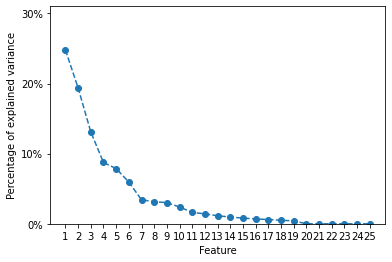

In [14]:
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.0,0.31,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.31,.1)]);
plt.ylim([0.0,0.31]);

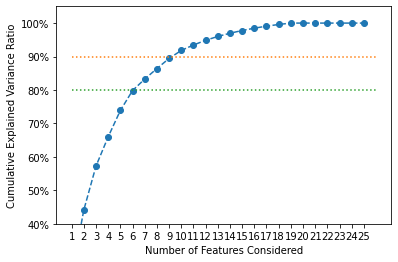

In [15]:
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,x_max],[.9,.9],':');
plt.plot([0,x_max],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

In [16]:
feature_selection_pca_model = PCA(n_components=10)
fitted_model = feature_selection_pca_model.fit(df_norm[input_variables])

X_selected_features_pca = fitted_model.transform(df_norm[input_variables])
print("    Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

    Explained Variance = 0.918
Reduced data set shape = (648, 10)


In [17]:
pca_model = linear_model.LinearRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, y, cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

PCA Model R2 Mean 0.525 StdDev 0.117


#Random Forest feature importance

In [18]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(df_norm[input_variables], df_norm[target_variable])
importances = forest.feature_importances_
importances

array([0.04773031, 0.37629442, 0.        , 0.        , 0.00816954,
       0.01337528, 0.0092411 , 0.00591916, 0.01643936, 0.        ,
       0.        , 0.01538147, 0.02450407, 0.02305156, 0.00823213,
       0.02013745, 0.01278673, 0.        , 0.        , 0.04359171,
       0.02432216, 0.09472632, 0.03193986, 0.01425663, 0.20990071])

Feature ranking:
 1. feature  1   Hours (0.376)
 2. feature 24 traffic (0.210)
 3. feature 21   tc_no (0.095)
 4. feature  0    Days (0.048)
 5. feature 19    tcco (0.044)
 6. feature 22   gtco3 (0.032)
 7. feature 12     tmp (0.025)
 8. feature 20   tcno2 (0.024)
 9. feature 13  sp_hum (0.023)
10. feature 15 tmp_shift_8 (0.020)
11. feature  8     tcc (0.016)
12. feature 11      sp (0.015)
13. feature 23    tcwv (0.014)
14. feature  5     v10 (0.013)
15. feature 16 tot_wind_shift_12 (0.013)
16. feature  6     hcc (0.009)
17. feature 14 tot_wind (0.008)
18. feature  4     u10 (0.008)
19. feature  7     lcc (0.006)
20. feature  9     cvl (0.000)
21. feature 17  height (0.000)
22. feature  3    long (0.000)
23. feature  2     lat (0.000)
24. feature 18   built (0.000)
25. feature 10     cvh (0.000)


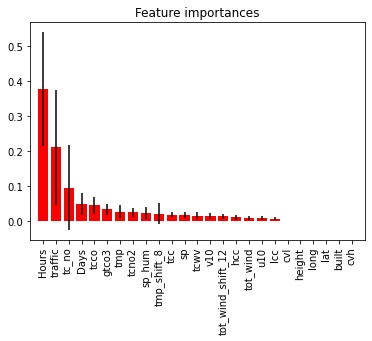

In [19]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[input_variables].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[input_variables].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_norm[input_variables].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[input_variables].shape[1]), df_norm[input_variables].columns[indices],rotation=90)
plt.xlim([-1, df_norm[input_variables].shape[1]])
plt.show()

#Split train and test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_norm[input_variables], df_norm[target_variable], test_size=0.20, random_state=42)

#XGboost regressor

In [21]:
XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train, verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE [s] = ', MAE )

[17:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE [s] =  0.024829568916039407


[]

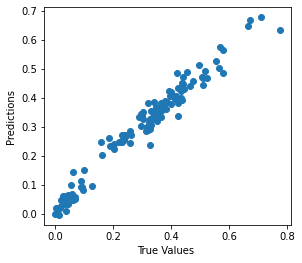

In [22]:
test_predictions = XGBpredictions

a = plt.axes(aspect='equal')
plt.scatter(y_test.values.tolist(), test_predictions.tolist())
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.plot()

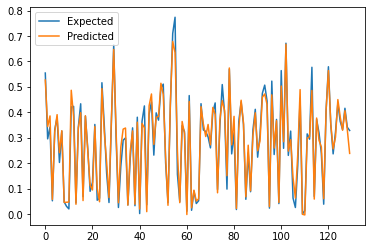

In [23]:
pyplot.plot(y_test.values.tolist(), label='Expected')
pyplot.plot(test_predictions.tolist(), label='Predicted')
pyplot.legend()
pyplot.show()